# Analyze Heavy Correlations

This jupyter notebook analyzes one-time correlations calculated from the heavy trajectories of ReadRun.py

Observables are:
- Self-intermediate scattering function
- Mean-square displacement
- Force-force correlations
- Velocity-velocity correlations
- Force-velocity correlations

In [2]:
from __future__ import print_function #for compatibility between python 2 and 3
import hoomd #hoomd is the MD package from the Glotzer group
from hoomd import md #md is the subsection strictly about the properties of the system
import sys
import os 
import numpy as np
import gsd.pygsd
import gsd.hoomd
import lib.module_measurements as med
from gsd import fl
from freud.box import Box
from matplotlib import pyplot as plt

## Import data

In [39]:
dt=0.0025
t0dir='ht220000'

#Read list of times
timesName='./heavyTraj/'+t0dir+'/times.txt'
timelist=np.loadtxt(timesName)
ntimes=len(timelist)

#Read trajectory
trajName='./heavyTraj/'+t0dir+'/traj.gsd'
traj = gsd.hoomd.HOOMDTrajectory(fl.GSDFile(trajName,'rb'))
box = traj[-1].configuration.box
fbox = Box(Lx=box[0],Ly=box[1],Lz=box[2],xy=box[3],xz=box[4],yz=box[5])
L=box[0]
pos = []
vel = []
for f in traj:
    pos.append(np.copy(f.particles.position))
    vel.append(np.copy(f.particles.velocity))
if len(pos)!= ntimes:
    raise ValueError('Time list is inconsistent with trajectory. ntimes=%d, len(pos)=%d'%(ntimes,len(pos)))

#Read accelerations
acc = []
facc=open('./heavyTraj/'+t0dir+'/acc.npy','rb')
for i in range(ntimes):
    acc.append(np.load(facc))
    count+=1
facc.close()

#Relevant quantities
Natoms=len(pos[0])
initialPositions=pos[0]
pos=np.array(pos)
vel=np.array(vel)
acc=np.array(acc)

## Calculate observables

In [40]:
#Wave vector for the self-intermediate scattring function
# k =[2 pi/L](n1,n2,n3) and permutations
n1=1
n2=3
n3=4

msd=np.zeros(ntimes, dtype=np.float64)
Fk=np.zeros(ntimes,dtype=np.float64)
for iframe in range(0, len(pos)):
    msd[iframe]=med.PeriodicSquareDistance(pos[iframe], initialPositions, L)/Natoms
    all_displacements=med.PeriodicDisplacement(pos[iframe], initialPositions, L)
    Fk[iframe]=med.ComputeFkt(n1, n2, n3, L, all_displacements)

CPP=np.array([np.mean([np.inner(vel[0][atom],vel[time][atom]) for atom in range(Natoms)]) for time in range(ntimes)])/3.
CFP=np.array([np.mean([np.inner(acc[0][atom],vel[time][atom]) for atom in range(Natoms)]) for time in range(ntimes)])/3.
CFF=np.array([np.mean([np.inner(acc[0][atom],acc[time][atom]) for atom in range(Natoms)]) for time in range(ntimes)])/3.




## Plot

### Mean Square Displacement

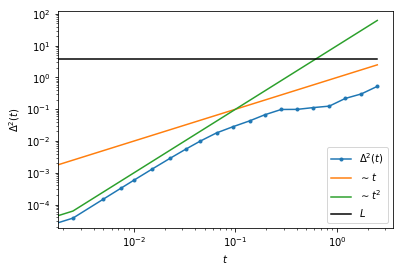

In [41]:
x=np.array(timelist-timelist[0])*dt
plt.loglog(x,msd,label='$\Delta^2(t)$',marker='.')
plt.loglog(x,x,label='$\sim t$')
plt.loglog(x,10*np.square(x),label='$\sim t^2$')
plt.loglog(x,box[0]*np.ones(len(x)),label='$L$',color='black')
plt.ylabel('$\Delta^2(t)$')
plt.xlabel('$t$')
plt.legend()
plt.show()

### Self-intermediate scattering function

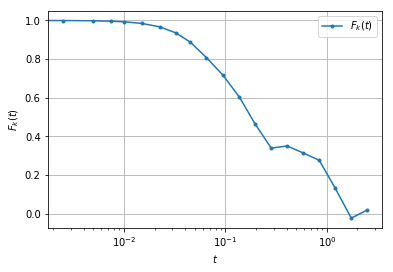

In [42]:
plt.semilogx(x,Fk,label='$F_k(t)$',marker='.')
plt.legend()
plt.ylabel('$F_k(t)$')
plt.xlabel('$t$')
plt.grid()
plt.show()

### Momentum-momentum correlation function

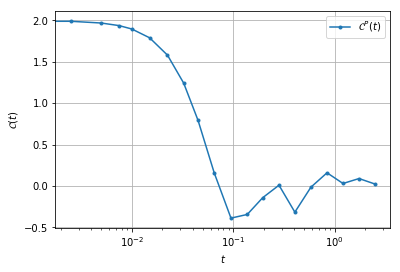

In [43]:
plt.semilogx(x,CPP,label='$\mathcal{C}^{P}(t)$',marker='.')
plt.legend()
plt.ylabel('$\mathcal{C}(t)$')
plt.xlabel('$t$')
plt.grid()
plt.show()

### Force-momentum correlation function

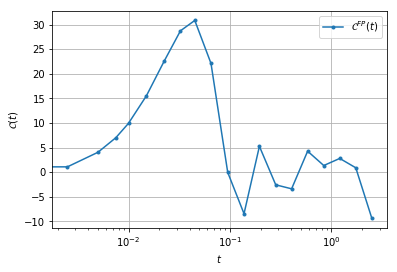

array([ -1.83738172e+00,   1.09640646e+00,   4.05556774e+00,
         7.01365137e+00,   9.93651867e+00,   1.55101433e+01,
         2.25893841e+01,   2.87215118e+01,   3.08271885e+01,
         2.21028233e+01,  -2.36989334e-02,  -8.42004585e+00,
         5.26439047e+00,  -2.55553484e+00,  -3.36371350e+00,
         4.27828884e+00,   1.36705673e+00,   2.80505180e+00,
         9.04353380e-01,  -9.31474304e+00], dtype=float32)

In [46]:
plt.semilogx(x,CFP,label='$\mathcal{C}^{FP}(t)$',marker='.')
plt.legend()
plt.ylabel('$\mathcal{C}(t)$')
plt.xlabel('$t$')
plt.grid()
plt.show()
CFP

### Force-force correlation function

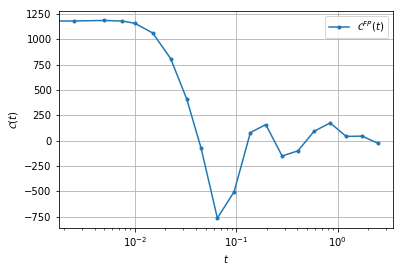

In [45]:
plt.semilogx(x,CFF,label='$\mathcal{C}^{FP}(t)$',marker='.')
plt.legend()
plt.ylabel('$\mathcal{C}(t)$')
plt.xlabel('$t$')
plt.grid()
plt.show()